In [2]:
import pandas as pd
import numpy as np

# ================= CONFIG =================
FILE_NAME = "customer_conversion.csv"   # 👈 change only file name
# ==========================================

# Load dataset
df = pd.read_csv(FILE_NAME)

# Auto-detect target column (assumes last column is target)
TARGET_COL = df.columns[-1]
print("✅ Detected target column:", TARGET_COL)

# Separate features and target
y = df[TARGET_COL]
X = df.drop(TARGET_COL, axis=1)

# Handle missing values
for col in X.columns:
    if X[col].dtype == "object":
        X[col].fillna(X[col].mode()[0], inplace=True)
    else:
        X[col].fillna(X[col].median(), inplace=True)

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

print("✅ Final feature shape:", X.shape)
print("✅ Target info:")
print(y.value_counts())
print("Target dtype:", y.dtype)


✅ Detected target column: converted
✅ Final feature shape: (1000, 7)
✅ Target info:
converted
0    990
1     10
Name: count, dtype: int64
Target dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_11068\1868252640.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_11068\1868252640.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

In [3]:
from sklearn.model_selection import train_test_split

# ---------- Auto-detect ML task ----------
if y.dtype == "object" or y.nunique() <= 10:
    TASK_TYPE = "classification"
else:
    TASK_TYPE = "regression"

print("✅ Detected task type:", TASK_TYPE)

# ---------- Safe train-test split ----------
if TASK_TYPE == "classification":
    # Use stratify only if possible
    if y.value_counts().min() < 2:
        print("⚠️ Stratify disabled (rare class detected)")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
else:
    # Regression → no stratify
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

print("✅ Train shape:", X_train.shape)
print("✅ Test shape:", X_test.shape)


✅ Detected task type: classification
✅ Train shape: (800, 7)
✅ Test shape: (200, 7)


In [4]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    mean_squared_error,
    r2_score
)

# ---------- Train Decision Tree ----------
if TASK_TYPE == "classification":
    dt = DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced"
    )
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_test)

    print("🌳 Decision Tree – Classification Results")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1]))

else:
    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_test)

    print("🌳 Decision Tree – Regression Results")
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R2 Score:", r2_score(y_test, y_pred))


🌳 Decision Tree – Classification Results
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       198
           1       0.00      0.00      0.00         2

    accuracy                           0.96       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.98      0.96      0.97       200

ROC-AUC: 0.48737373737373735


In [5]:
import pandas as pd

print("\n🔍 Overfitting Experiment (varying max_depth)\n")

depths = [None, 3, 5, 10]

for depth in depths:
    if TASK_TYPE == "classification":
        model = DecisionTreeClassifier(
            max_depth=depth,
            random_state=42,
            class_weight="balanced"
        )
    else:
        model = DecisionTreeRegressor(
            max_depth=depth,
            random_state=42
        )

    model.fit(X_train, y_train)

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"Depth: {depth} | Train Score: {train_score:.4f} | Test Score: {test_score:.4f}")

# ---------- Feature Importance ----------
print("\n🌟 Feature Importance\n")

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": dt.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(importance_df.head(10))



🔍 Overfitting Experiment (varying max_depth)

Depth: None | Train Score: 1.0000 | Test Score: 0.9650
Depth: 3 | Train Score: 0.7250 | Test Score: 0.7800
Depth: 5 | Train Score: 0.9550 | Test Score: 0.9450
Depth: 10 | Train Score: 0.9975 | Test Score: 0.9650

🌟 Feature Importance

                Feature  Importance
6      engagement_score    0.448315
4  discount_sensitivity    0.270310
5        location_score    0.166438
1        monthly_income    0.060737
0                   age    0.046681
2         browsing_time    0.007444
3    previous_purchases    0.000075


Epoch 1/100


c:\Users\User\Downloads\007\.conda\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8094 - loss: 0.5119 - val_accuracy: 0.9937 - val_loss: 0.3042
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9812 - loss: 0.2491 - val_accuracy: 0.9937 - val_loss: 0.1424
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9891 - loss: 0.1620 - val_accuracy: 0.9937 - val_loss: 0.0883
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9891 - loss: 0.1082 - val_accuracy: 0.9937 - val_loss: 0.0687
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9891 - loss: 0.0922 - val_accuracy: 0.9937 - val_loss: 0.0627
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9891 - loss: 0.0904 - val_accuracy: 0.9937 - val_loss: 0.0597
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9891 - loss: 0.0912 - val_accuracy: 0.9937 - val_loss: 0.0592
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9891 - loss: 0.0796 - val_accuracy: 0.9937 - val_loss: 0.

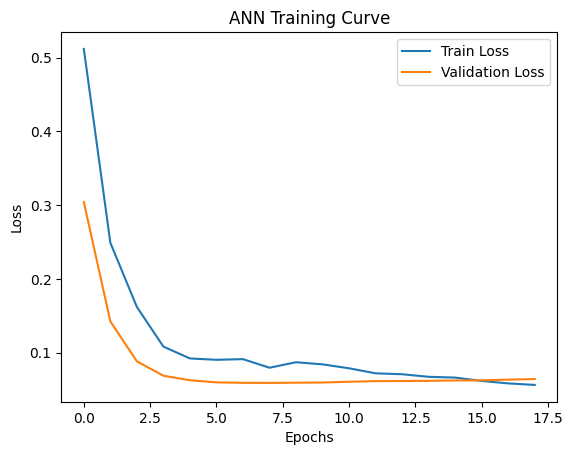

In [6]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

# ---------- Scaling (ANN needs it) ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------- Build ANN ----------
def build_ann(neurons=64, dropout=0.3, lr=0.001):
    model = keras.Sequential()

    model.add(layers.Dense(
        neurons,
        activation="relu",
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train_scaled.shape[1],)
    ))
    model.add(layers.Dropout(dropout))

    model.add(layers.Dense(neurons // 2, activation="relu"))
    model.add(layers.Dropout(dropout))

    # 🔁 Auto output layer + loss
    if TASK_TYPE == "classification":
        model.add(layers.Dense(1, activation="sigmoid"))
        loss_fn = "binary_crossentropy"
        metrics = ["accuracy"]
    else:
        model.add(layers.Dense(1, activation="linear"))
        loss_fn = "mse"
        metrics = ["mae"]

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=loss_fn,
        metrics=metrics
    )

    return model


# ---------- Train ANN ----------
model = build_ann()

history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
    verbose=1
)

# ---------- Evaluate ----------
print("\n🧠 ANN Evaluation")

results = model.evaluate(X_test_scaled, y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# ---------- Loss Curve ----------
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Training Curve")
plt.show()
